In [2]:
import pandas as pd
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import hashlib
import numpy as np
from esm import pretrained, FastaBatchedDataset
import torch
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
import re
import subprocess
from predict import defense_predictor
from predict import get_representations
import warnings
import random
from core import read_dom_table, read_mmseqs_results
import gpplot

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

## Download genomes and sequences

In [4]:
def unzip_file(file):
    os.system('gunzip ' + file)


def encode_protein(p):
    return hashlib.sha224(p.encode('utf-8')).hexdigest()


def process_seq(seq, name, assembly, f):
    seq_id = encode_protein(seq)
    print(','.join([name, seq_id, seq, assembly]), file=f)


def process_faa_file(faa_dir, faa_file, out_dir):
    assembly = faa_file.split('.')[0]
    with open(out_dir + assembly + '.csv', 'w') as f:
        seq = ''
        for line in open(faa_dir + faa_file, 'r'):
            if '>' in line:
                if seq:
                    process_seq(seq, name, assembly, f)
                    seq = ''
                name = line.split(' ')[0][1:]
            else:
                seq += line.strip()
        process_seq(seq, name, assembly, f)


def process_unique_split(out_dir, unique_seq_df, i):
    with open(out_dir + str(i) + '.faa', 'w') as f:
        for _, row in unique_seq_df.iterrows():
            print('>' + row['name'], file=f)
            print(row['seq'], file=f)

In [5]:
def hmmsearch(tblout, database, input_file, cutoff=1E-2):
    # fixed total targets for comparison with other 
    rand = random.randint(0, 1_000_000_000)
    os.system(' '.join(['conda run -n beaker', 
                        'hmmsearch',
                        '-o', '../data/tmp/tmpfile_' + str(rand) + '.txt',
                        '--domtblout', tblout,
                        '-E', str(cutoff), 
                        '--domE', str(cutoff),
                        '--cpu', '2',
                        database,
                        input_file]))
    os.system('rm ../data/tmp/tmpfile_' + str(rand) + '.txt')

In [6]:
assemblies_dir = '../data/interim/ecor_assemblies/'

In [4]:
print('Unzipping files')
files = [file for file in os.listdir(assemblies_dir) if '.gz' in file]
_ = Parallel(n_jobs=40)(delayed(unzip_file)(assemblies_dir + f) for f in tqdm(files))

Unzipping files


100%|██████████| 142/142 [00:01<00:00, 82.73it/s]


In [7]:
faa_files = [file for file in os.listdir(assemblies_dir) if '.faa' in file]

In [8]:
seq_assembly_dir = '../data/interim/ecor_assemblies_faa_temp/'
print('Deduplicating fasta files')
os.system('mkdir ' + seq_assembly_dir)
_ = Parallel(n_jobs=40)(delayed(process_faa_file)(assemblies_dir, faa_file, seq_assembly_dir) for faa_file in tqdm(faa_files))
os.system('cat ' + seq_assembly_dir + '*.csv > ../data/interim/ecor_seq_assemblies.csv')
os.system('rm -r ' + seq_assembly_dir)

Deduplicating fasta files


100%|██████████| 69/69 [00:00<00:00, 90.55it/s]


0

In [ ]:
seq_assembly_df = pd.read_csv('../data/interim/ecor_seq_assemblies.csv',
                              names=['name', 'seq_id', 'seq', 'assembly'])
unique_seq_df = seq_assembly_df[['name', 'seq']].drop_duplicates()
rm_rows = len(seq_assembly_df) - len(unique_seq_df)
print('Removed', rm_rows, 'of rows (', rm_rows/len(seq_assembly_df)*100, '%)')

Removed 240537 of rows ( 75.09647085268995 %)


In [ ]:
len(unique_seq_df)

79767

In [ ]:
ecor_unique_seqs_fa = '../data/interim/ecor_unique_seqs.faa'

In [12]:
unique_seq_dir = '../data/interim/ecor_unique_seqs_temp/'
print('Writing deduplicated sequences')
os.mkdir(unique_seq_dir)
unique_seq_df = np.array_split(unique_seq_df, 1_000)
Parallel(n_jobs=40)(delayed(process_unique_split)(unique_seq_dir, df, i) for i, df in tqdm(enumerate(unique_seq_df), total=1_000))
os.system('cat ' + unique_seq_dir + '*.faa > ' + ecor_unique_seqs_fa)
os.system('rm -r ' + unique_seq_dir)

Writing deduplicated sequences


100%|██████████| 1000/1000 [00:00<00:00, 1172.39it/s]


0

## Get representations for sequences

In [8]:
rep_file = '../data/interim/ecor_representations_reps.csv' # output

In [10]:
rep_output_dir = '../data/interim/'
if 'ecor_representations_reps.csv' not in os.listdir('../data/interim'):
    print('Calculating assembly representations')
    model_location = 'esm2_t30_150M_UR50D'
    toks_per_batch = 4096
    truncation_seq_length = 1022
    repr_layer = 30
    model, alphabet = pretrained.load_model_and_alphabet(model_location)
    device = torch.device('cuda')
    print('Model device:', device)
    model = model.to(device)
    repr_layer = (repr_layer + model.num_layers + 1) % (model.num_layers + 1)
    print('Repr layer', repr_layer)
    get_representations('../data/interim/ecor_unique_seqs.faa', 'ecor_representations', 
                        rep_output_dir, toks_per_batch, alphabet,
                        truncation_seq_length, model, repr_layer, 'cuda')
else:
    warnings.warn('Representation directory already exists')

Calculating assembly representations
Model device: cuda
Repr layer 30


100%|██████████| 7495/7495 [27:28<00:00,  4.55it/s]


## Make Beaker Predictions

In [9]:
feature_files = [file for file in os.listdir(assemblies_dir) if file.endswith('.txt')]
fna_files = [file for file in os.listdir(assemblies_dir) if file.endswith('.fna')]
faa_files = [file for file in os.listdir(assemblies_dir) if file.endswith('.faa')]

In [10]:
feature_file_dict = {x.split('.')[0]: '../data/interim/ecor_assemblies/' + x for x in feature_files}
fna_file_dict = {x.split('.')[0]: '../data/interim/ecor_assemblies/' + x for x in fna_files}
faa_file_dict = {x.split('.')[0]: '../data/interim/ecor_assemblies/' + x for x in faa_files}
assemblies = feature_file_dict.keys()

In [11]:
prediction_out_dir = '../data3/processed/ecor_predictions/'

In [13]:
if not os.path.exists(prediction_out_dir):
    os.mkdir(prediction_out_dir)
    x_file_dict = None
else:
    X_files = [x for x in os.listdir(prediction_out_dir) if x.endswith('_X.pq')]
    x_file_dict = {x.split('_X')[0]: prediction_out_dir + x for x in X_files}

In [14]:
rep_df = pd.read_csv('../data/interim/ecor_representations_reps.csv', 
                     names=['ft' + str(i+1) for i in range(640)])

In [16]:
pred_list = list()
model_mat_dict = dict()
for assembly in tqdm(assemblies):
    feature_file = feature_file_dict[assembly]
    fna_file = fna_file_dict[assembly]
    faa_file = faa_file_dict[assembly]
    if x_file_dict is not None:
        X = pd.read_parquet(x_file_dict[assembly])
    else:
        X = None
    preds, model_mat = defense_predictor(feature_file, fna_file, 
                                         faa_file, rep_df=rep_df, 
                                         model_feature_df=X)
    pred_list.append(preds)
    model_mat_dict[assembly] = model_mat

  0%|          | 0/69 [00:00<?, ?it/s]

Making predictions


  1%|▏         | 1/69 [00:06<07:10,  6.33s/it]

Making predictions


  3%|▎         | 2/69 [00:10<05:22,  4.81s/it]

Making predictions


  4%|▍         | 3/69 [00:13<04:36,  4.20s/it]

Making predictions


  6%|▌         | 4/69 [00:16<04:07,  3.80s/it]

Making predictions


  7%|▋         | 5/69 [00:19<03:48,  3.57s/it]

Making predictions


  9%|▊         | 6/69 [00:23<03:54,  3.72s/it]

Making predictions


 10%|█         | 7/69 [00:26<03:36,  3.49s/it]

Making predictions


 12%|█▏        | 8/69 [00:29<03:18,  3.26s/it]

Making predictions


 13%|█▎        | 9/69 [00:32<03:10,  3.18s/it]

Making predictions


 14%|█▍        | 10/69 [00:35<03:07,  3.19s/it]

Making predictions


 16%|█▌        | 11/69 [00:38<03:02,  3.14s/it]

Making predictions


 17%|█▋        | 12/69 [00:42<03:09,  3.32s/it]

Making predictions


 19%|█▉        | 13/69 [00:46<03:09,  3.38s/it]

Making predictions


 20%|██        | 14/69 [00:49<03:09,  3.44s/it]

Making predictions


 22%|██▏       | 15/69 [00:52<03:01,  3.35s/it]

Making predictions


 23%|██▎       | 16/69 [00:56<02:58,  3.38s/it]

Making predictions


 25%|██▍       | 17/69 [00:59<02:49,  3.25s/it]

Making predictions


 26%|██▌       | 18/69 [01:02<02:44,  3.22s/it]

Making predictions


 28%|██▊       | 19/69 [01:05<02:35,  3.10s/it]

Making predictions


 29%|██▉       | 20/69 [01:08<02:37,  3.22s/it]

Making predictions


 30%|███       | 21/69 [01:12<02:40,  3.34s/it]

Making predictions


 32%|███▏      | 22/69 [01:16<02:41,  3.43s/it]

Making predictions


 33%|███▎      | 23/69 [01:19<02:36,  3.40s/it]

Making predictions


 35%|███▍      | 24/69 [01:22<02:35,  3.45s/it]

Making predictions


 36%|███▌      | 25/69 [01:26<02:33,  3.50s/it]

Making predictions


 38%|███▊      | 26/69 [01:30<02:31,  3.51s/it]

Making predictions


 39%|███▉      | 27/69 [01:33<02:27,  3.52s/it]

Making predictions


 41%|████      | 28/69 [01:37<02:29,  3.65s/it]

Making predictions


 42%|████▏     | 29/69 [01:40<02:12,  3.31s/it]

Making predictions


 43%|████▎     | 30/69 [01:43<02:10,  3.34s/it]

Making predictions


 45%|████▍     | 31/69 [01:47<02:10,  3.42s/it]

Making predictions


 46%|████▋     | 32/69 [01:51<02:11,  3.57s/it]

Making predictions


 48%|████▊     | 33/69 [01:54<02:11,  3.66s/it]

Making predictions


 49%|████▉     | 34/69 [01:58<02:09,  3.69s/it]

Making predictions


 51%|█████     | 35/69 [02:01<02:00,  3.56s/it]

Making predictions


 52%|█████▏    | 36/69 [02:05<01:55,  3.50s/it]

Making predictions


 54%|█████▎    | 37/69 [02:08<01:45,  3.29s/it]

Making predictions


 55%|█████▌    | 38/69 [02:11<01:45,  3.39s/it]

Making predictions


 57%|█████▋    | 39/69 [02:15<01:45,  3.50s/it]

Making predictions


 58%|█████▊    | 40/69 [02:19<01:44,  3.61s/it]

Making predictions


 59%|█████▉    | 41/69 [02:22<01:40,  3.57s/it]

Making predictions


 61%|██████    | 42/69 [02:26<01:36,  3.57s/it]

Making predictions


 62%|██████▏   | 43/69 [02:30<01:33,  3.59s/it]

Making predictions


 64%|██████▍   | 44/69 [02:33<01:26,  3.44s/it]

Making predictions


 65%|██████▌   | 45/69 [02:36<01:23,  3.48s/it]

Making predictions


 67%|██████▋   | 46/69 [02:40<01:20,  3.52s/it]

Making predictions


 68%|██████▊   | 47/69 [02:43<01:15,  3.42s/it]

Making predictions


 70%|██████▉   | 48/69 [02:48<01:20,  3.82s/it]

Making predictions


 71%|███████   | 49/69 [02:51<01:14,  3.74s/it]

Making predictions


 72%|███████▏  | 50/69 [02:55<01:09,  3.65s/it]

Making predictions


 74%|███████▍  | 51/69 [02:58<01:01,  3.39s/it]

Making predictions


 75%|███████▌  | 52/69 [03:01<00:57,  3.39s/it]

Making predictions


 77%|███████▋  | 53/69 [03:05<00:55,  3.47s/it]

Making predictions


 78%|███████▊  | 54/69 [03:08<00:51,  3.45s/it]

Making predictions


 80%|███████▉  | 55/69 [03:12<00:50,  3.62s/it]

Making predictions


 81%|████████  | 56/69 [03:16<00:48,  3.70s/it]

Making predictions


 83%|████████▎ | 57/69 [03:19<00:43,  3.62s/it]

Making predictions


 84%|████████▍ | 58/69 [03:23<00:39,  3.60s/it]

Making predictions


 86%|████████▌ | 59/69 [03:26<00:35,  3.59s/it]

Making predictions


 87%|████████▋ | 60/69 [03:29<00:30,  3.34s/it]

Making predictions


 88%|████████▊ | 61/69 [03:32<00:26,  3.29s/it]

Making predictions


 90%|████████▉ | 62/69 [03:36<00:23,  3.30s/it]

Making predictions


 91%|█████████▏| 63/69 [03:39<00:20,  3.39s/it]

Making predictions


 93%|█████████▎| 64/69 [03:43<00:16,  3.36s/it]

Making predictions


 94%|█████████▍| 65/69 [03:46<00:13,  3.40s/it]

Making predictions


 96%|█████████▌| 66/69 [03:49<00:09,  3.31s/it]

Making predictions


 97%|█████████▋| 67/69 [03:52<00:06,  3.20s/it]

Making predictions


 99%|█████████▊| 68/69 [03:56<00:03,  3.26s/it]

Making predictions


100%|██████████| 69/69 [03:59<00:00,  3.46s/it]


In [17]:
cat_pred_df = pd.concat(pred_list)

In [18]:
(cat_pred_df['mean_log_odds'] > 0).sum()

4279

## Search ecor collection for homologs of known systems

In [16]:
def run_defense_finder(assembly_file, out_dir):
    assembly_stub = assembly_file.split('.')[0]
    assembly_out_dir = out_dir + assembly_stub
    os.mkdir(assembly_out_dir)
    subprocess.run(['conda',
                    'run',
                    '-n',
                    'beaker',
                    'defense-finder', 'run', 
                    '-w', '1',
                    '-o', assembly_out_dir,
                    '../data/interim/ecor_assembly_faa/' + assembly_file], 
                   stdout=subprocess.DEVNULL)

In [13]:
faa_dir = '../data/interim/ecor_assembly_faa/'

In [9]:
os.mkdir(faa_dir)

In [12]:
for f in faa_files:
    os.system('cp ../data/interim/ecor_assemblies/' + f + ' ' + faa_dir)

In [19]:
ecor_df_dir = '../data/interim/ecor_defense_finder_results/'

In [17]:
_ = Parallel(n_jobs=40)(delayed(run_defense_finder)
                        (f, ecor_df_dir) 
                         for f in tqdm(assembly_files))

100%|██████████| 71/71 [00:04<00:00, 15.21it/s]


In [20]:
defense_finder_results_dir = [x for x in os.listdir('../data/interim/ecor_defense_finder_results/') if 'GCF' in x]


In [21]:
defense_genes_list = []
defense_hmmer_list = []
for assembly in tqdm(defense_finder_results_dir):
    genes_df = pd.read_csv('../data/interim/ecor_defense_finder_results/' + assembly + '/' + 'defense_finder_genes.tsv', 
                           sep='\t')
    genes_df['assembly'] = assembly
    defense_genes_list.append(genes_df)
    hmmer_df = pd.read_csv('../data/interim/ecor_defense_finder_results/' + assembly + '/' + 'defense_finder_hmmer.tsv', 
                           sep='\t')
    hmmer_df['assembly'] = assembly
    defense_hmmer_list.append(hmmer_df)


100%|██████████| 69/69 [00:06<00:00, 11.24it/s]


In [22]:
defense_finder_homologs = pd.concat(defense_hmmer_list)
defense_finder_homologs['protein_assembly'] = defense_finder_homologs['hit_id'] + '_' + defense_finder_homologs['assembly']
unique_defense_finder_homologs = defense_finder_homologs['protein_assembly'].unique()
dedup_defense_finder_homolog_df = (defense_finder_homologs.groupby('protein_assembly')
                                   .agg(defense_homolog_names=('gene_name', lambda x: ', '.join(x)))
                                   .reset_index())

In [23]:
defense_finder_systems = pd.concat(defense_genes_list)
defense_finder_systems['protein_assembly'] = defense_finder_systems['hit_id'] + '_' + defense_finder_systems['assembly']
unique_defense_finder_systems = defense_finder_systems['protein_assembly'].unique()
breif_defense_finder_systems = defense_finder_systems[['protein_assembly', 'sys_id']]

In [24]:
merged_predictions = cat_pred_df
merged_predictions['assembly_stub'] = merged_predictions['assembly'].str.split('.', expand=True)[0]
merged_predictions['protein_assembly'] = merged_predictions['product_accession'] + '_' + merged_predictions['assembly_stub']
merged_predictions['defense_homolog'] = merged_predictions['protein_assembly'].isin(unique_defense_finder_homologs)
merged_predictions['defense_system_protein'] = merged_predictions['protein_assembly'].isin(unique_defense_finder_systems)
merged_predictions = (merged_predictions.merge(dedup_defense_finder_homolog_df, how='left', 
                                               on='protein_assembly')
                      .merge(breif_defense_finder_systems, how='left', on='protein_assembly'))


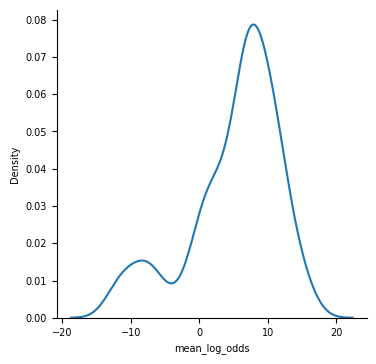

In [25]:
plt.subplots(figsize=(4,4))
sns.kdeplot(data=merged_predictions[merged_predictions['defense_system_protein']], x='mean_log_odds')
sns.despine()

In [26]:
((merged_predictions['mean_log_odds'] > 0) &
 (~merged_predictions['defense_homolog'])).sum()

2501

## Define operons by runs seperated by <30 bp on the same strand

In [27]:
sorted_predictions = merged_predictions.sort_values(['genomic_accession', 'start'], ascending=True)

In [28]:
max_gap = 30
first = True
operon_list = []
for _, row in tqdm(sorted_predictions.iterrows(), 
                   total=len(sorted_predictions),
                   position=0):
    curr_start = row['start']
    curr_accession = row['genomic_accession']
    curr_strand = row['strand']
    if first:
        operon = curr_accession + '|' + str(curr_start) + '|' + curr_strand
        first = False
    else:
        if (((curr_start - prev_end) > max_gap) or 
            (curr_accession != prev_accession) or 
            (curr_strand != prev_strand)):
            operon = curr_accession + '|' + str(curr_start) + '|' + curr_strand
    operon_list.append(operon)
    prev_end = row['end']
    prev_accession = row['genomic_accession']
    prev_strand = row['strand']
    

100%|██████████| 321347/321347 [00:15<00:00, 20960.50it/s]


In [29]:
sorted_predictions['operon'] = operon_list

## Mark operons at the edge of each contig

In [30]:
sorted_predictions['contig_end'] = (sorted_predictions.groupby('genomic_accession')
                                    .apply(lambda df: (df['start'] == df['start'].min()) | 
                                               (df['end'] == df['end'].max()))
                                    .reset_index(level=0, drop=True))

## Cluster proteins into homologous groups

In [34]:
conda_commands = ['conda', 'run', '-n', 'beaker']

In [ ]:
target = ecor_unique_seqs_fa
target_db = '../data/interim/mmseqs_working_dir/ecor_unique_seqs_db'
out_db = '../data3/interim/mmseqs_dbs/ecor_unique_seqs_db_clust'
threads = str(48)

In [32]:
out_tsv = '../data3/interim/ecor_clusters.tsv'

In [52]:
os.system(' '.join(conda_commands +
                   ['mmseqs createdb ' + target + ' ' + target_db + ' --dbtype 1']))

createdb ../data/interim/ecor_unique_seqs.faa ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db --dbtype 1 

MMseqs Version:       	13.45111
Database type         	1
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[=======
Time for merging to ecor_unique_seqs_db_h: 0h 0m 0s 140ms
Time for merging to ecor_unique_seqs_db: 0h 0m 0s 184ms
Database type: Aminoacid
Time for processing: 0h 0m 1s 27ms



0

In [53]:
os.system(' '.join(conda_commands +
                   ['mmseqs createindex ' + target_db + ' ../data/tmp']))

createindex ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/tmp 

MMseqs Version:          	13.45111
Seed substitution matrix 	nucl:nucleotide.out,aa:VTML80.out
k-mer length             	0
Alphabet size            	nucl:5,aa:21
Compositional bias       	1
Max sequence length      	65535
Max results per query    	300
Mask residues            	1
Mask lower case residues 	0
Spaced k-mers            	1
Spaced k-mer pattern     	
Sensitivity              	7.5
k-score                  	0
Check compatible         	0
Search type              	0
Split database           	0
Split memory limit       	0
Verbosity                	3
Threads                  	96
Min codons in orf        	30
Max codons in length     	32734
Max orf gaps             	2147483647
Contig start mode        	2
Contig end mode          	2
Orf start mode           	1
Forward frames           	1,2,3
Reverse frames           	1,2,3
Translation table        	1
Translate orf            	0
Use all table starts     	f

0

In [37]:
os.system(' '.join(conda_commands +
                   ['mmseqs cluster', target_db,
                    out_db, '$TMPDIR',
                    '-c 0.8',
                    '--min-seq-id 0.3',
                    '--threads', threads,
                    '--cluster-mode 0', 
                    '--cov-mode 0', 
                    '-s 6']))  

cluster ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data3/interim/mmseqs_dbs/ecor_unique_seqs_db_clust /state/partition1/slurm_tmp/1081985.0.0 -c 0.8 --min-seq-id 0.3 --threads 48 --cluster-mode 0 --cov-mode 0 -s 6 

MMseqs Version:                     	13.45111
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	6
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mas

0

In [38]:
os.system(' '.join(conda_commands + 
                   ['mmseqs createtsv', 
                    target_db, target_db, 
                    out_db, 
                    out_tsv]))

createtsv ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data/interim/mmseqs_working_dir/ecor_unique_seqs_db ../data3/interim/mmseqs_dbs/ecor_unique_seqs_db_clust ../data3/interim/ecor_clusters.tsv 

MMseqs Version:                 	13.45111
First sequence as representative	false
Target column                   	1
Add full header                 	false
Sequence source                 	0
Database output                 	false
Threads                         	96
Compressed                      	0
Verbosity                       	3

Time for merging to ecor_clusters.tsv: 0h 0m 1s 961ms
Time for processing: 0h 0m 4s 804ms



0

In [33]:
clusters = pd.read_table(out_tsv, 
                         names=['cluster_id', 'product_accession'])

In [34]:
cluster_merged_preds = (sorted_predictions.merge(clusters, how='inner', 
                                                    on='product_accession'))

## Remove close homologs in MG1655 (>90% ID and coverage)


In [35]:
working_dir = '../data/interim/mmseqs_working_dir/'
mg1655_query = '../data/external/GCF_000005845.2_ASM584v2_protein.faa'
mg1655_db = working_dir + 'mg1655_db'


In [ ]:
os.system(' '.join(conda_commands + 
                   ['mmseqs createdb', 
                    mg1655_query, mg1655_db]))

In [36]:
ecor_seqs_db = '../data/interim/mmseqs_working_dir/ecor_unique_seqs_db'
ecor_mg_search_out = '../data/interim/mmseqs_working_dir/ecor_mg1655_search'

In [ ]:
os.system(' '.join(conda_commands +
                   ['mmseqs',
                    'search',
                    ecor_seqs_db,
                    mg1655_db, 
                    ecor_mg_search_out, 
                    '../data/tmp',
                    '--threads 48',
                    '-a']))

In [37]:
ecor_mg_search_final_out = '../data/interim/ecor_mg_homologs.txt'

In [ ]:
os.system(' '.join(conda_commands +
          ['mmseqs convertalis', 
           ecor_seqs_db, 
           mg1655_db, 
           ecor_mg_search_out, 
           ecor_mg_search_final_out,
           '--threads 48', 
           '--format-output query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov']))

In [38]:
ecor_mg_homolog_df = read_mmseqs_results(ecor_mg_search_final_out)

In [39]:
close_homolog_df = ecor_mg_homolog_df[(ecor_mg_homolog_df['fident'] > 0.9) & 
                                      (ecor_mg_homolog_df['qcov'] > 0.9)]


In [40]:
ecor_mg1655_close_homologs = close_homolog_df['query'].unique()
len(ecor_mg1655_close_homologs)


49684

In [41]:
close_homolog_df['target'].nunique()

4162

In [42]:
cluster_merged_preds['MG1655_homolog'] = cluster_merged_preds['product_accession'].isin(ecor_mg1655_close_homologs)

## Output

In [43]:
cluster_merged_preds.to_csv('../data3/interim/ecor_predictions.csv', index=False)

In [59]:
if x_file_dict is None:
    for assembly, assembly_x in tqdm(model_mat_dict.items(), position=0):
        assembly_x.to_parquet(os.path.join(prediction_out_dir, assembly + '_X.pq'))

In [4]:
old_predictions = pd.read_csv('../data/interim/ecor_predictions.csv')
cluster_merged_preds = pd.read_csv('../data3/interim/ecor_predictions.csv')

/state/partition1/slurm_tmp/1760358.0.0/ipykernel_1164092/3584972170.py:1: DtypeWarning: Columns (21,27) have mixed types. Specify dtype option on import or set low_memory=False.
  old_predictions = pd.read_csv('../data/interim/ecor_predictions.csv')
/state/partition1/slurm_tmp/1760358.0.0/ipykernel_1164092/3584972170.py:2: DtypeWarning: Columns (24,30) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_merged_preds = pd.read_csv('../data3/interim/ecor_predictions.csv')


In [5]:
old_predictions['log_odds'] = np.log(old_predictions['beaker_prediction']/(1-old_predictions['beaker_prediction']))

In [6]:
all_merged_predictions = (cluster_merged_preds.merge(old_predictions[['protein_context_id', 'log_odds']], 
                                                     how='inner', on='protein_context_id'))

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

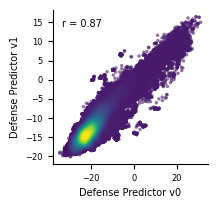

In [8]:
plt.subplots(figsize=(2,2))
gpplot.point_densityplot(data=all_merged_predictions, x='log_odds', y='mean_log_odds', s=5)
gpplot.add_correlation(data=all_merged_predictions, x='log_odds', y='mean_log_odds')
sns.despine()
plt.xlabel('Defense Predictor v0')
plt.ylabel('Defense Predictor v1')
plt.savefig('../figures/dp_v1_v2.svg', bbox_inches='tight', dpi=300)

In [56]:
all_merged_predictions['delta'] = all_merged_predictions['mean_log_odds'] - all_merged_predictions['log_odds']
all_merged_predictions['new_hit'] = ((all_merged_predictions['mean_log_odds'] > 0) & 
                                     (all_merged_predictions['log_odds'] < 0))
all_merged_predictions['old_hit'] = ((all_merged_predictions['mean_log_odds'] < 0) & 
                                     (all_merged_predictions['log_odds'] > 0))

In [57]:
(all_merged_predictions.query('new_hit').sort_values('mean_log_odds', ascending=False)
 .groupby('cluster_id')
 .head(1)
 .head(20) 
 [['protein_context_id', 'name', 'symbol', 'mean_log_odds', 'sd_log_odds', 'log_odds']])

,protein_context_id,name,symbol,mean_log_odds,sd_log_odds,log_odds
299380,WP_000862379.1|NZ_RRUY01000001.1|200242|-,TIR domain-containing protein,NaN,7.565467,4.189072,-4.360515
13999,WP_001288850.1|NZ_RRVY01000002.1|17679|-,chromosome partition protein MukF,mukF,6.815987,1.794817,-6.217645
139060,WP_097343845.1|NZ_QOWS01000001.1|266175|+,DNA adenine methylase,NaN,5.981363,2.976073,-1.207657
254205,WP_000824184.1|NZ_QOYI01000134.1|2364|-,hypothetical protein,NaN,3.688827,3.819142,-5.713343
254634,WP_000783855.1|NZ_QOYJ01000014.1|40112|+,DNA adenine methylase,NaN,3.388867,2.935681,-2.957667
314826,WP_086415151.1|NZ_RRVY01000015.1|3221|-,toll/interleukin-1 receptor domain-containing ...,NaN,3.282785,1.231273,-1.439543
204658,WP_000104146.1|NZ_QOXR01000004.1|34542|+,DNA adenine methylase,NaN,3.276985,4.671619,-3.301881
158360,WP_000586175.1|NZ_QOWT01000054.1|3588|-,hypothetical protein,NaN,3.094490,3.386048,-3.872491
123447,WP_001295931.1|NZ_RRVV01000014.1|4665|-,chromosome partition protein MukE,mukE,3.053576,3.129308,-8.410378
170025,WP_001567921.1|NZ_QOWZ01000022.1|4342|-,DNA adenine methylase,NaN,2.872617,3.212437,-5.692939


In [58]:
(all_merged_predictions.query('old_hit').sort_values('log_odds', ascending=False)
 .groupby('cluster_id')
 .head(1)
 .head(20) 
 [['protein_context_id', 'name', 'symbol', 'mean_log_odds', 'sd_log_odds', 'log_odds']])

,protein_context_id,name,symbol,mean_log_odds,sd_log_odds,log_odds
160937,WP_000208382.1|NZ_QOYQ01000011.1|362448|-,DUF6088 family protein,NaN,-0.287845,1.930048,17.549826
311078,WP_097311032.1|NZ_RRVF01000061.1|24145|+,Mov34/MPN/PAD-1 family protein,NaN,-1.771182,1.688892,15.546505
178953,WP_000357807.1|NZ_QOXQ01000045.1|28194|+,OmpA family protein,NaN,-3.951241,2.545136,15.288170
159986,WP_000020778.1|NZ_QOYT01000066.1|11614|-,TatD family hydrolase,NaN,-4.802853,0.835294,14.994752
311377,WP_063930100.1|NZ_RRVF01000109.1|1020|-,ImmA/IrrE family metallo-endopeptidase,NaN,-1.053324,1.983924,14.714579
175085,WP_001416755.1|NZ_RRVF01000012.1|95095|-,type I-E CRISPR-associated endoribonuclease Cas2e,cas2e,-0.255831,1.812746,14.541435
277969,WP_000192872.1|NZ_QOYU01000054.1|2816|+,hypothetical protein,NaN,-1.826668,1.015055,13.746411
166035,WP_000210436.1|NZ_QOWX01000046.1|16489|-,ATP-binding protein,NaN,-0.888991,1.318196,13.732205
201691,WP_071337424.1|NZ_QOXQ01000009.1|26780|+,cGAMP-activated phospholipase CapV,capV,-0.911930,3.985926,13.583309
270324,WP_000099232.1|NZ_QOYQ01000045.1|1457|+,WYL domain-containing protein,NaN,-4.580885,2.683587,13.125983
